In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

### Inverting sequence
ex) '1', '2', '5', '2', '2', '6', '5', '1' -> '1', '5', '6', '2', '2', '5', '2', '1'

In [11]:
from my_utils import Dictionary

n_unique = 10

src_dict = Dictionary(['<EOS>'])
tgt_dict = Dictionary(['<BOS>', '<EOS>'])
for n in range(n_unique):
    src_dict.add_word(str(n))
    tgt_dict.add_word(str(n))

In [12]:
from my_utils.toy_data import invert_seq
train = invert_seq(5000, n_unique=n_unique)
test = invert_seq(100, n_unique=n_unique)

In [13]:
import torch
from my_utils import DataLoader
from torch_models.utils import seq2seq

def numericalize(dataset, src_dict, tgt_dict):
    numericalized = [([src_dict(s) for s in src], [tgt_dict(t) for t in tgt]) for src, tgt in dataset]
    return numericalized

# device = 'cuda:0'
device = torch.device('cpu')
trans_func = seq2seq(device)

train_loader = DataLoader(numericalize(train, src_dict, tgt_dict), batch_size=64, trans_func=trans_func)
test_loader = DataLoader(numericalize(test, src_dict, tgt_dict), batch_size=16, trans_func=trans_func)

In [14]:
from torch_models import AttnSeq2Seq, Seq2Seq
dim = 100
model = AttnSeq2Seq(dim, dim, len(src_dict), len(tgt_dict),
                    tgt_BOS=tgt_dict('<BOS>'), tgt_EOS=tgt_dict('<EOS>'), src_EOS=src_dict('<EOS>'),
                    num_layers=1, bidirectional=True, rnn='lstm').to(device)
print(model)

AttnSeq2Seq(
  (encoder): RNNEncoder(
    (embedding): Embedding(12, 100, padding_idx=11)
    (rnn): LSTM(100, 100, bidirectional=True)
  )
  (decoder): RNNEncoder(
    (embedding): Embedding(13, 100, padding_idx=12)
    (rnn): LSTM(100, 200)
  )
  (generator): MLP(
    (fc_out): Linear(in_features=200, out_features=12, bias=True)
    (dropout): Dropout(p=0)
    (criterion): CrossEntropyLoss()
    (activation): Tanh()
  )
  (attn_hidden): Linear(in_features=400, out_features=200, bias=True)
  (attention): DotAttn()
)


In [20]:
%%time
from my_utils import Trainer, EvaluatorSeq
from torch.optim import Adam, SGD

optimizer = Adam(model.parameters())
# optimizer = SGD(model.parameters(), lr=0.0001)

evaluator = EvaluatorSeq(model, test_loader, measure='BLEU')

trainer = Trainer(model, train_loader)
trainer.train(optimizer, max_epoch=3,
              evaluator=evaluator, score_monitor=None, show_log=True, hook_func=None)

epoch 0  	loss: 0.004043992543578313	BLEU: 0.915125760003862	


KeyboardInterrupt: 

In [19]:
model.get_attn = True
iter(train_loader)
model.attn_weights = []
l = 1
inputs, target = next(train_loader)
generated = model.predict(inputs[:l])
print('======= input ======')
for seq in inputs[:l]:
    print([src_dict[s.item()] for s in seq])
print('======= output ======')
for seq in generated[:l]:
    print([tgt_dict[s] for s in seq])

======= input ======
['0', '7', '3', '7', '7']
======= output ======
['7', '7', '3', '7', '0']


<IPython.core.display.Javascript object>


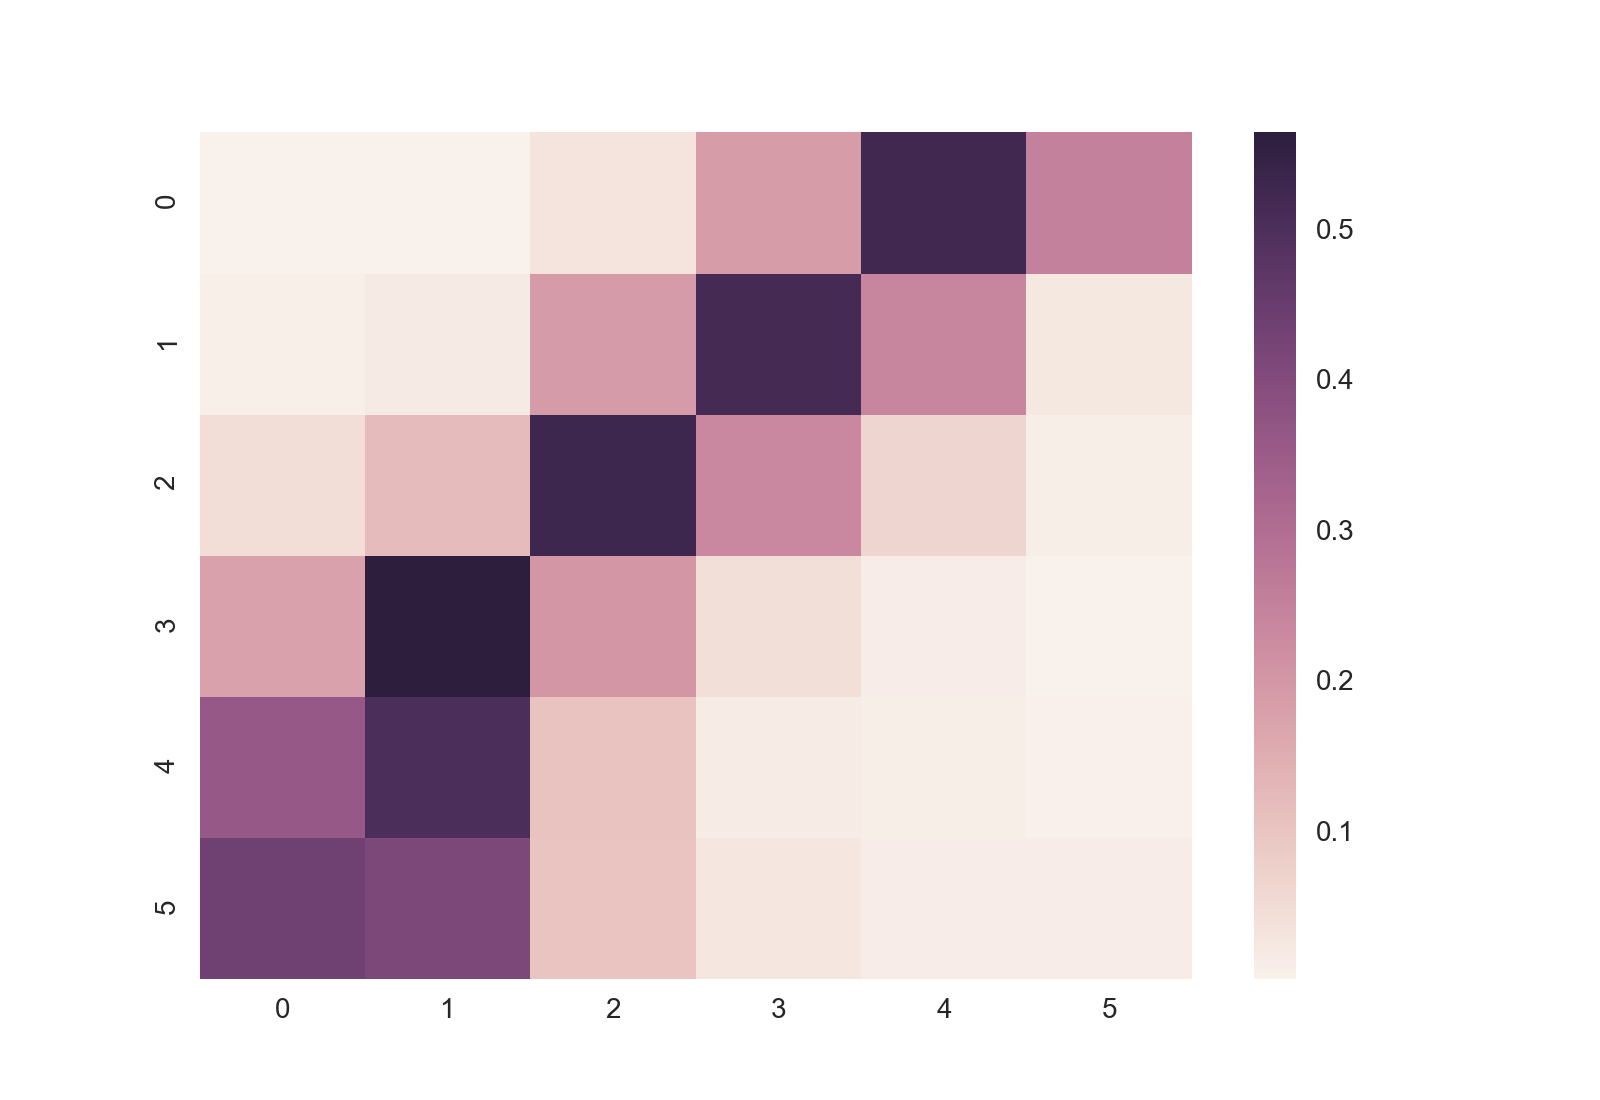

In [11]:
import torch
import seaborn as sns
sns.heatmap(torch.stack(model.attn_weights).squeeze().data.cpu().numpy())